Loading files...

--- Plotting Initial State ---

---------- Initial State Stats ----------
Avg Util (Occupied)      : 27.68%
Global Density           : 0.0078
Occupied Bins            : 10
Total Bins               : 357
Heavy Violations         : 0 (OK)
Misplaced A-Items        : 3 (!)
Total Travel Cost        : 351,460.00
---------------------------------------------

[Visualizer] Drawing Top View Heatmap for 37 stacks.
[Visualizer] Plot saved to: C:\Users\arthu\Desktop\DIT\CS IntSys\REPO\IntelligentSystemsCaseStudy\Prototype_phase_1\Metrics and Visualization\plots\plot_001_top_view.png


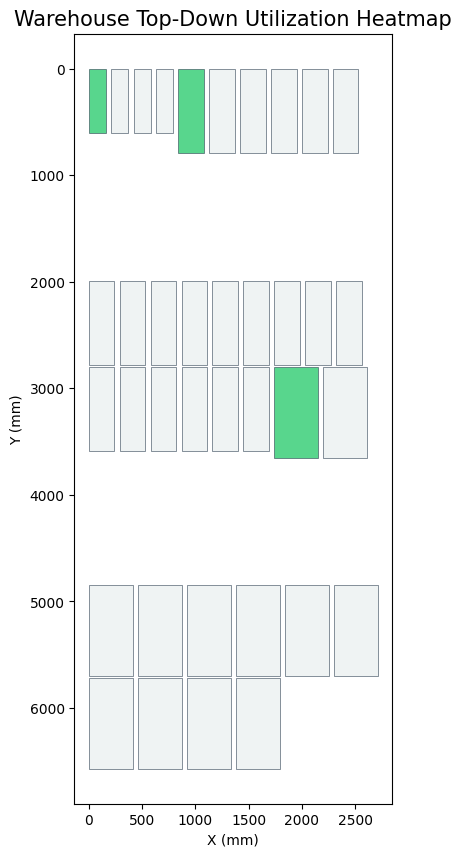

[Visualizer] Drawing Front View for 37 rack columns.
[Visualizer] Plot saved to: C:\Users\arthu\Desktop\DIT\CS IntSys\REPO\IntelligentSystemsCaseStudy\Prototype_phase_1\Metrics and Visualization\plots\plot_002_front_view.png


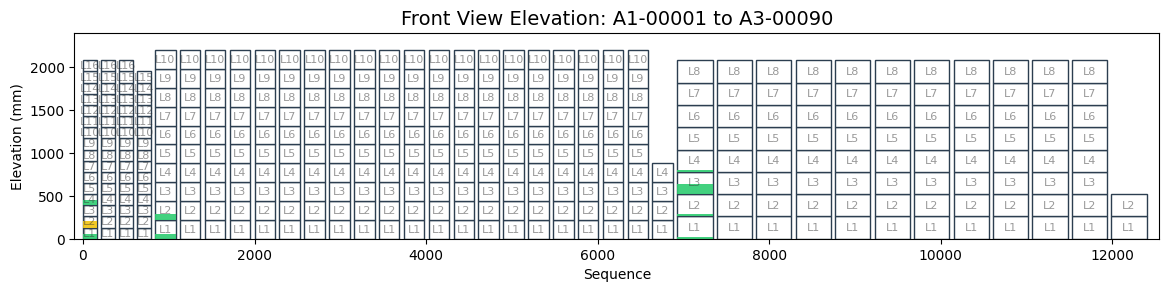


--- Executing Move Logic ---
Moving Item: 79924774
Source Location: A1-00001
Location Type: A1
Target Location found (Empty): A1-00005
Move executed successfully.

--- Plotting Final State ---

---------- Final State Stats ----------
Avg Util (Occupied)      : 27.68%
Global Density           : 0.0078
Occupied Bins            : 10
Total Bins               : 357
Heavy Violations         : 0 (OK)
Misplaced A-Items        : 3 (!)
Total Travel Cost        : 351,980.00
---------------------------------------------

[Visualizer] Drawing Top View Heatmap for 37 stacks.
[Visualizer] Plot saved to: C:\Users\arthu\Desktop\DIT\CS IntSys\REPO\IntelligentSystemsCaseStudy\Prototype_phase_1\Metrics and Visualization\plots\plot_003_top_view.png


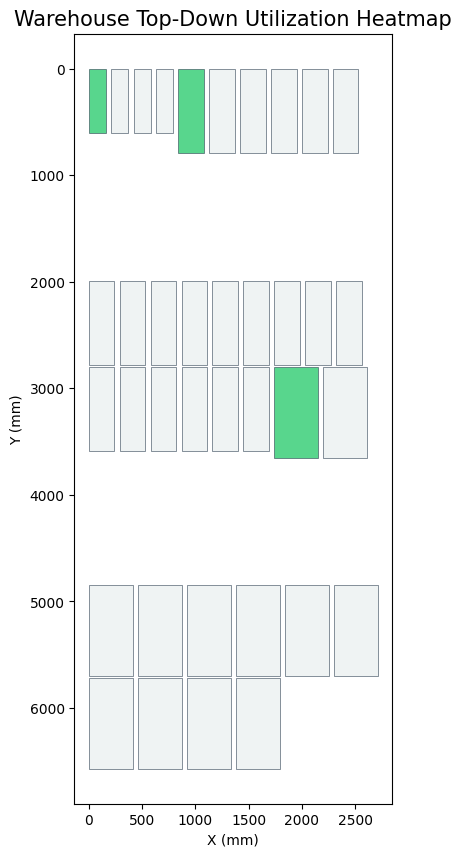

[Visualizer] Drawing Front View for 37 rack columns.
[Visualizer] Plot saved to: C:\Users\arthu\Desktop\DIT\CS IntSys\REPO\IntelligentSystemsCaseStudy\Prototype_phase_1\Metrics and Visualization\plots\plot_004_front_view.png


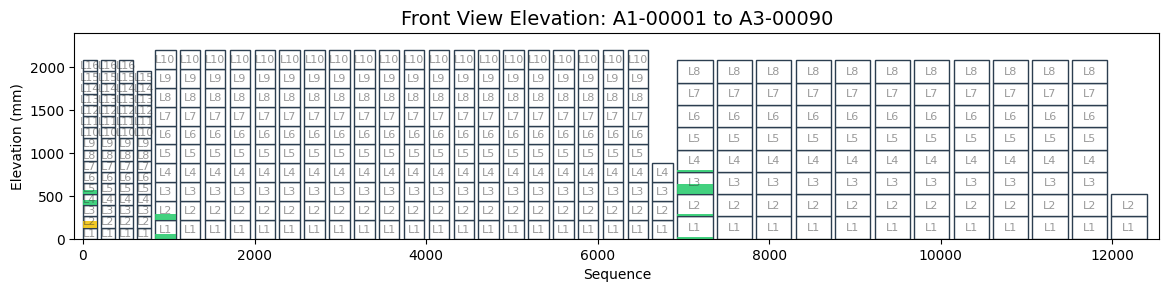

In [1]:
import pandas as pd
import metrics_viz_lib as viz  # Importing the separate library

# ==========================================
# 1. LOAD AND PREPROCESS DATA
# ==========================================

# 1.1 Read Files
# Note: Ensure the files are in the same directory as this notebook
print("Loading files...")
try:
    df_locations = pd.read_csv('locations_dummy.csv')
    # The synthetic parts file uses a semicolon separator based on the sample provided
    df_items = pd.read_csv('synthetic_parts_generated.csv', sep=';')
    df_alloc = pd.read_csv('allocations.csv')
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    exit()

# 1.2 Preprocess Allocation Data
# The library expects: 'LOCATION_ID', 'SKU', 'utilization' (float 0-1)
# The file has: 'LOC_CODE', 'ITEM_ID', 'UTILIZATION_PCT' (float 0-100)
df_alloc_clean = df_alloc.copy()
df_alloc_clean = df_alloc_clean.rename(columns={
    'LOC_CODE': 'LOCATION_ID',
    'ITEM_ID': 'SKU',
    'UTILIZATION_PCT': 'utilization'
})

# Convert percentage (0-100) to ratio (0.0-1.0)
df_alloc_clean['utilization'] = df_alloc_clean['utilization'] / 100.0

# Remove rows where allocation failed (UNFIT)
df_alloc_clean = df_alloc_clean[df_alloc_clean['LOCATION_ID'] != 'UNFIT']

# ==========================================
# 2. PLOT INITIAL STATE
# ==========================================
print("\n--- Plotting Initial State ---")

# Merge data using the library function
df_initial_state = viz.prepare_unified_dataframe(df_alloc_clean, df_locations, df_items)

# Calculate and print stats
stats_init = viz.calculate_warehouse_stats(df_initial_state)
viz.print_stats_pretty(stats_init, title="Initial State Stats") 

# Plot Top View
viz.plot_top_view_heatmap(df_initial_state)

# Plot Front View (Entire range)
start_loc = df_locations['loc_inst_code'].min()
end_loc = df_locations['loc_inst_code'].max()
viz.plot_front_view(df_initial_state, start_loc, end_loc)

# ==========================================
# 3. MOVE LOGIC
# ==========================================
print("\n--- Executing Move Logic ---")

# 3.1 Identify items in the first allocation row
# We take the first row from the active allocations
first_alloc_row = df_alloc_clean.iloc[0]
item_to_move = first_alloc_row['SKU']
source_loc_id = first_alloc_row['LOCATION_ID']

print(f"Moving Item: {item_to_move}")
print(f"Source Location: {source_loc_id}")

# 3.2 Find Source Location Type
source_loc_info = df_locations[df_locations['loc_inst_code'] == source_loc_id]
if source_loc_info.empty:
    print(f"Error: Source location {source_loc_id} not found in locations file.")
else:
    loc_type = source_loc_info.iloc[0]['loc_type']
    print(f"Location Type: {loc_type}")

    # 3.3 Find Destination Candidate
    # Logic: Same Type, different ID. 
    # Preference: Find an empty bin first to avoid overlapping logic in this simple script.
    
    # All locations of the same type excluding source
    candidates = df_locations[
        (df_locations['loc_type'] == loc_type) & 
        (df_locations['loc_inst_code'] != source_loc_id)
    ]
    
    # Get list of currently occupied locations
    occupied_locs = df_alloc_clean['LOCATION_ID'].unique()
    
    # Filter candidates to find one that is NOT occupied
    empty_candidates = candidates[~candidates['loc_inst_code'].isin(occupied_locs)]
    
    target_loc_id = None
    
    if not empty_candidates.empty:
        target_loc_id = empty_candidates.iloc[0]['loc_inst_code']
        print(f"Target Location found (Empty): {target_loc_id}")
    elif not candidates.empty:
        # If no empty bins, pick the first available of same type (will double stack)
        target_loc_id = candidates.iloc[0]['loc_inst_code']
        print(f"No empty bins. Target Location found (Occupied): {target_loc_id}")
    else:
        print("No valid target location found.")

    # 3.4 Execute Move
    if target_loc_id:
        # Update the LOCATION_ID in the allocation dataframe for the specific item/source combo
        # Note: If the file had unique IDs per allocation, we would use that. 
        # Here we use index 0 because we explicitly selected iloc[0].
        df_alloc_clean.iloc[0, df_alloc_clean.columns.get_loc('LOCATION_ID')] = target_loc_id
        print("Move executed successfully.")

# ==========================================
# 4. PLOT FINAL STATE
# ==========================================
print("\n--- Plotting Final State ---")

# Re-merge data with updated allocations
df_final_state = viz.prepare_unified_dataframe(df_alloc_clean, df_locations, df_items)

# Calculate and print stats
stats_final = viz.calculate_warehouse_stats(df_final_state)
viz.print_stats_pretty(stats_final, title="Final State Stats")

# Plot Top View
viz.plot_top_view_heatmap(df_final_state)

# Plot Front View
viz.plot_front_view(df_final_state, start_loc, end_loc)